In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading Train and Test datasets

In [2]:
df_train = pd.read_csv('train_inc.csv')
df_test = pd.read_csv('test_inc.csv')

In [3]:
df_train.columns.unique()

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object', length=143)

In [4]:
df_test.columns

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       'agesq'],
      dtype='object', length=142)

In [5]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


### 1. Identify the output variable.

In [6]:
for k in df_train.columns:
    if k not in df_test.columns:
        print(k)

Target


Hence, the column named 'Target' is abset in Test dataset

### 2. Understand the type of data.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


let us check for the columns **not required** for the prediction

In [9]:
df_train.select_dtypes(include='object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [10]:
def map(i):
    
    if i=='yes':
        return(float(1))
    elif i=='no':
        return(float(0))
    else:
        return(float(i))

In [11]:
df_train['dependency']=df_train['dependency'].apply(map)
df_train['edjefe']=df_train['edjefe'].apply(map)
df_train['edjefa']=df_train['edjefa'].apply(map)

In [12]:
df_test['dependency']=df_test['dependency'].apply(map)
df_test['edjefe']=df_test['edjefe'].apply(map)
df_test['edjefa']=df_test['edjefa'].apply(map)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(11), int64(130), object(2)
memory usage: 10.4+ MB


The object dtypes features ('dependency', 'edjefe', 'edjefa') have been converted to integers.

In [14]:
zero_var = df_train.var()[df_train.var()==0].index.values

In [15]:
zero_var

array(['elimbasu5'], dtype=object)

Here, the feature 'elimbasu5' is the only one with zero variance. 

-> elimbasu1 = 1, if rubbish disposal mainly by tanker truck

Hence, it will be dropped in future.

### 3. Check if there are any biases in your dataset.

In [16]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


In [17]:
df_train.groupby('Target')['Target'].count()

Target
1     755
2    1597
3    1209
4    5996
Name: Target, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

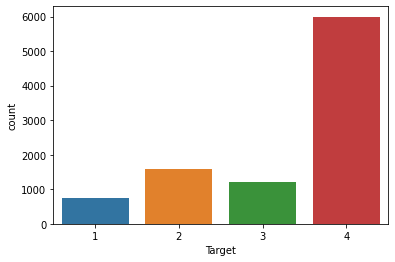

In [18]:
sns.countplot(df_train.Target)

Here, extreme poverty is 1 and 4 being the least poverty.

The above chart clearly shows that the train dataset is highly biased towards class 4.


In [19]:
contingency_tab = pd.crosstab(df_train['hacdor'],df_train['hacapo'])
Observed_Values = contingency_tab.values
import scipy.stats
b = scipy.stats.chi2_contingency(contingency_tab)
Expected_Values = b[3]
no_of_rows = len(contingency_tab.iloc[0:2,0])
no_of_columns = len(contingency_tab.iloc[0,0:2])
df = (no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",df)

Degree of Freedom:- 1


In [20]:
from scipy.stats import chi2
chi_square = sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic = chi_square[0] + chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
alpha = 0.05
critical_value = chi2.ppf(q = 1-alpha, df = df)
print('critical_value:',critical_value)

chi-square statistic:- 4070.1186996667257
critical_value: 3.841458820694124


In [21]:
p_value = 1-chi2.cdf(x = chi_square_statistic, df = df)
print('p-value:',p_value)
print('Significance level: ',alpha)

p-value: 0.0
Significance level:  0.05


In [22]:
if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

Reject H0,There is a relationship between 2 categorical variables


In [23]:
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

Reject H0,There is a relationship between 2 categorical variables


The chi-square value is greater that the critical value when alpha is 0.05.

The p-value is less than alpha.

This infers that the dataset is biased when degree of freedom is 1.

### 4. Check whether all members of the house have the same poverty level.

In [24]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


In [25]:
equal_house = df_train.groupby('idhogar')['Target'].apply(lambda X: X.nunique() == 1) 

Here, equal_house is the household with same poverty level

And, unequal_house is the household with un-equal poverty level

In [26]:
unequal_house = equal_house[equal_house != True]
print("The number of households, where the family members do not have the same level of poverty, are: {}".format(len(unequal_house)))

The number of households, where the family members do not have the same level of poverty, are: 85


### 5. Check if there is a house without a family head.

In [27]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


Here, we are looking for house_head = households with family head and house_no_head = households with no family head

In [28]:
house_head = df_train.groupby('idhogar')['parentesco1'].sum()

In [29]:
house_no_head = df_train.loc[df_train['idhogar'].isin(house_head[house_head == 0].index), :]
print('The households without family head: ', house_no_head["idhogar"].nunique())

The households without family head:  15


Hence, the households without family head are 15

### 6. Set poverty level of the members and the head of the house within a family.

Here, we will only look into the households with family head with unequal poverty level

In [30]:
for house in unequal_house.index:
#Finding the correct label(label of house head)
    family_head_target = int(df_train[(df_train['idhogar'] == house) & (df_train['parentesco1'] == 1.0)] ['Target'])
#Setting the correct label for family members
    family_head_target = df_train.loc[df_train['idhogar'] == house, 'Target']

#Now setting poverty level of the members same as the head of the house within a family.
#Iterating through each household

### 7. Count how many null values are existing in columns.

In [31]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


In [32]:
null_info = pd.DataFrame(columns=['Column', 'No of Null'])

for i in range(0, len(df_train.columns)):
    null_info.loc[i] = [df_train.columns[i], df_train[df_train.columns[i]].isnull().sum()]

In [33]:
null_info

,Column,No of Null
0,Id,0
1,v2a1,6860
2,hacdor,0
3,rooms,0
4,hacapo,0
...,...,...
138,SQBovercrowding,0
139,SQBdependency,0
140,SQBmeaned,5
141,agesq,0


In [34]:
null_info[null_info['No of Null'] > 0]

,Column,No of Null
1,v2a1,6860
8,v18q1,7342
21,rez_esc,7928
103,meaneduc,5
140,SQBmeaned,5


### 8. Remove null value rows of the target variable.

In [35]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


In [36]:
null_info['No of Null'].sum()

22140

lets remove all the null values

In [37]:
df_train[df_train["Target"] == 0]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


In [38]:
df_train['Target'].isna().sum()

0

Now, the Target feature is free from null values

In [39]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


Now to perform **Data Cleaning** before applying ML model.

v2a1, **Monthly rent payment**

tipovivi1, =1 own and fully paid house

tipovivi2, "=1 own, paying in installments"

tipovivi3, =1 rented

tipovivi4, =1 precarious

tipovivi5, "=1 other(assigned, borrowed)"

In [40]:
df_train['v2a1'].isna().sum()

6860

In [41]:
df_train[['v2a1','tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']].isna().sum()

v2a1         6860
tipovivi1       0
tipovivi2       0
tipovivi3       0
tipovivi4       0
tipovivi5       0
dtype: int64

In [42]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


In [43]:
for data in [df_train, df_test]:
    data['v2a1'].fillna(value=0, inplace=True)

In [44]:
df_train[['v2a1']].isnull().sum()

v2a1    0
dtype: int64

v18q, owns a **tablet** ; here, 1 = owns and 0 = doesn't own

v18q1, number of tablets household owns

In [45]:
df_train[['v18q', 'v18q1']].isna().sum()

v18q        0
v18q1    7342
dtype: int64

In [46]:
df_test[['v18q', 'v18q1']].isna().sum()

v18q         0
v18q1    18126
dtype: int64

In [47]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


In [48]:
print('Tablet owned by the household \n', df_train['v18q'].value_counts())
print('\nNumber of Tablets owned by the household \n',df_train['v18q1'].value_counts())

Tablet owned by the household 
 0    7342
1    2215
Name: v18q, dtype: int64

Number of Tablets owned by the household 
 1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64


In [49]:
for df in [df_train, df_test]:
    df['v18q1'].fillna(value=0, inplace=True)
    
df_train['v18q1'].isnull().sum()

0

we have filled all the null values with zeros in 'v18q1' feature

rez_esc, **Years behind in school**

edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

**meaneduc**, average years of education for adults **(18+)**

**SQBmeaned**, square of the mean years of education of adults (>=18) in the household

instlevel1, =1 no level of education

instlevel2, =1 incomplete primary

instlevel3, =1 complete primary

instlevel4, =1 incomplete academic secondary level

instlevel5, =1 complete academic secondary level

instlevel6, =1 incomplete technical secondary level

instlevel7, =1 complete technical secondary level

instlevel8, =1 undergraduate and higher education

instlevel9, =1 postgraduate higher education

In [50]:
df_train['rez_esc'].isnull().sum()

7928

In [51]:
for data in [df_train, df_test]:
    data['rez_esc'].fillna(value = 0, inplace = True)

df_train['rez_esc'].isnull().sum()

0

In [52]:
df_test['rez_esc'].isnull().sum()

0

In [53]:
df_train[df_train['meaneduc'].isnull()].loc[:,['age','meaneduc','edjefe','edjefa','instlevel1','instlevel2',
                                      'instlevel3','instlevel4','instlevel5','instlevel6',
                                      'instlevel7','instlevel8','instlevel9']]

,age,meaneduc,edjefe,edjefa,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
1291,18,NaN,0.0,10.0,0,0,0,1,0,0,0,0,0
1840,18,NaN,4.0,0.0,0,0,1,0,0,0,0,0,0
1841,18,NaN,4.0,0.0,0,1,0,0,0,0,0,0,0
2049,19,NaN,12.0,0.0,0,0,0,0,0,0,1,0,0
2050,19,NaN,12.0,0.0,0,0,0,0,0,0,1,0,0


Here, we will fill the values in 'meaneduc' by the values from 'edjefe'.

In [54]:
for data in [df_train,df_test]:
    data['meaneduc'].fillna(value = data['edjefe'], inplace = True)
    
df_train['meaneduc'].isnull().sum()

0

In [55]:
df_train['meaneduc'].dtypes

dtype('float64')

In [56]:
df_train.loc[:,['Id','meaneduc','edjefe','edjefa','instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']].head()


,Id,meaneduc,edjefe,edjefa,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,ID_279628684,10.0,10.0,0.0,0,0,0,1,0,0,0,0,0
1,ID_f29eb3ddd,12.0,12.0,0.0,0,0,0,0,0,0,0,1,0
2,ID_68de51c94,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0
3,ID_d671db89c,11.0,11.0,0.0,0,0,0,1,0,0,0,0,0
4,ID_d56d6f5f5,11.0,11.0,0.0,0,0,0,0,1,0,0,0,0


In [57]:
pd.set_option('display.max_rows', 1000) 

Now, we will take a look into correlation matrix of this dataset.

In [58]:
corr_matrix = df_train.corr()
corr_matrix

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
v2a1,1.000000,-0.025479,0.101634,-0.030867,0.018355,0.061534,0.171947,0.196293,0.017916,-0.059021,...,0.191560,-0.106213,-0.023928,0.260639,0.009876,-0.045814,-0.073783,0.279741,-0.106213,0.166942
hacdor,-0.025479,1.000000,-0.233369,0.652594,-0.175011,-0.101965,-0.084680,-0.077992,0.232508,0.059313,...,-0.109862,-0.102725,0.350546,-0.082229,0.388043,0.794699,0.005278,-0.099153,-0.102725,-0.191714
rooms,0.101634,-0.233369,1.000000,-0.213368,0.129183,0.130531,0.254256,0.271554,-0.066578,0.267627,...,0.233679,0.068288,0.221595,0.198890,0.007952,-0.355526,-0.027575,0.250061,0.068288,0.226208
hacapo,-0.030867,0.652594,-0.213368,1.000000,-0.150986,-0.124506,-0.067529,-0.061785,0.226378,0.126645,...,-0.092703,-0.075528,0.373720,-0.071170,0.367025,0.640096,0.014411,-0.103324,-0.075528,-0.138008
v14a,0.018355,-0.175011,0.129183,-0.150986,1.000000,0.143143,0.036396,0.031774,-0.054769,0.018133,...,0.036483,0.023831,0.009100,0.018897,-0.015193,-0.174969,0.005712,0.034711,0.023831,0.063382
refrig,0.061534,-0.101965,0.130531,-0.124506,0.143143,1.000000,0.086002,0.063927,-0.047087,-0.022819,...,0.097128,0.025846,-0.052195,0.082159,-0.108718,-0.123054,-0.034080,0.117406,0.025846,0.126792
v18q,0.171947,-0.084680,0.254256,-0.067529,0.036396,0.086002,1.000000,0.849916,-0.024318,-0.014489,...,0.250477,-0.054670,-0.016430,0.282619,-0.050562,-0.125936,-0.071504,0.302763,-0.054670,0.238864
v18q1,0.196293,-0.077992,0.271554,-0.061785,0.031774,0.063927,0.849916,1.000000,0.003278,-0.002031,...,0.229343,-0.053372,0.002936,0.308742,-0.027454,-0.114650,-0.066708,0.289304,-0.053372,0.201754
r4h1,0.017916,0.232508,-0.066578,0.226378,-0.054769,-0.047087,-0.024318,0.003278,1.000000,-0.088267,...,-0.186017,-0.272690,0.441126,-0.031240,0.565494,0.355660,-0.036977,-0.083552,-0.272690,-0.229889
r4h2,-0.059021,0.059313,0.267627,0.126645,0.018133,-0.022819,-0.014489,-0.002031,-0.088267,1.000000,...,-0.017251,-0.054712,0.509087,0.077610,0.124701,0.144478,-0.157357,-0.062217,-0.054712,0.101253


Now, we will select the upper triangle of the correlation matrix. Also, we will select among the features with correlation below 95% and will drop these.

In [59]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

#Finding the index of feature columns with correlation greater than 0.95
cols_to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

cols_to_drop

['tamhog',
 'hhsize',
 'coopele',
 'female',
 'hogar_total',
 'area2',
 'SQBage',
 'SQBhogar_total',
 'agesq']

In [60]:
df_train.drop(columns = cols_to_drop, axis=1, inplace = True)
df_test.drop(columns = cols_to_drop, axis=1, inplace = True)

In [61]:
print(df_train.shape)
print(df_test.shape)

(9557, 134)
(23856, 133)


Also we gotta drop columns: ID, male, idhogar, SQBescolari, SQBedjefe, SQBhogar_nin, SQBovercrowding, SQBdependency

Because these features will not contribute to the predictions.

In [62]:
cols_to_drop1 = ['Id','male', 'idhogar', 'SQBescolari', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned']

In [63]:
df_train.drop(columns = cols_to_drop1, axis=1, inplace = True)
df_test.drop(columns = cols_to_drop1, axis=1, inplace = True)

In [64]:
df_train.columns

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'qmobilephone', 'lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5',
       'lugar6', 'area1', 'age', 'Target'],
      dtype='object', length=125)

In [65]:
df_test.columns

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'mobilephone', 'qmobilephone', 'lugar1', 'lugar2', 'lugar3', 'lugar4',
       'lugar5', 'lugar6', 'area1', 'age'],
      dtype='object', length=124)

In [66]:
print(df_train.shape)
print(df_test.shape)

(9557, 125)
(23856, 124)


We will select the columns with data type float, in order to convert these to integer.

In [67]:
df_float = ['v2a1','v18q1','rez_esc','dependency','edjefe','edjefa','overcrowding', 'meaneduc']

In [68]:
df_train[df_float] = df_train[df_float].applymap(np.int64)
df_test[df_float] = df_test[df_float].applymap(np.int64)

In [69]:
df_train[['v2a1','v18q1','rez_esc','dependency','edjefe','edjefa','overcrowding']].isna().sum()

v2a1            0
v18q1           0
rez_esc         0
dependency      0
edjefe          0
edjefa          0
overcrowding    0
dtype: int64

In [70]:
print(df_train.dtypes)
print(df_test.dtypes)

v2a1               int64
hacdor             int64
rooms              int64
hacapo             int64
v14a               int64
refrig             int64
v18q               int64
v18q1              int64
r4h1               int64
r4h2               int64
r4h3               int64
r4m1               int64
r4m2               int64
r4m3               int64
r4t1               int64
r4t2               int64
r4t3               int64
tamviv             int64
escolari           int64
rez_esc            int64
paredblolad        int64
paredzocalo        int64
paredpreb          int64
pareddes           int64
paredmad           int64
paredzinc          int64
paredfibras        int64
paredother         int64
pisomoscer         int64
pisocemento        int64
pisoother          int64
pisonatur          int64
pisonotiene        int64
pisomadera         int64
techozinc          int64
techoentrepiso     int64
techocane          int64
techootro          int64
cielorazo          int64
abastaguadentro    int64


Now, we have the **integer** data type of the test and train datasets.

### 9. Predict the accuracy using random forest classifier.

Here, we will first assign the features to X and y.

In [71]:
X1 = df_train.drop('Target',axis=1)
y = df_train.Target

In [72]:
X_train_col = X1.columns

Now, we will apply standard scalingto the train dataset

In [73]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()

X = SS.fit_transform(X1)
X = pd.DataFrame(X1, columns = X_train_col)
# X_test = SS.fit_transform(X_test)

In [74]:
print(X.shape)
print(y.shape)

(9557, 124)
(9557,)


In [75]:
from sklearn.model_selection import train_test_split, KFold,cross_val_score

Now, we will fit the data into model

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25 ,random_state = 16)

In [77]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(9557, 124)
(2390, 124)
(9557,)
(2390,)


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Here, we will first use the Grid Search with RandomForest

In [79]:
rf_model = RandomForestClassifier(random_state=0)
params = {'n_estimators':[10,50,100,300],'max_depth':[3,5,10,15], 'bootstrap' : [True, False]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid= params)
best_=None

In [80]:
grid_search.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 5, 10, 15],
                         'n_estimators': [10, 50, 100, 300]})

In [81]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}

These, above, are the best parameters we get in RandomForest.

In [82]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report

In [83]:
y_pred = grid_search.predict(X_test)
print('Accuracy : ',accuracy_score(y_pred, y_test))

Accuracy :  0.6598326359832636


In [84]:
confusion_matrix(y_pred, y_test)

array([[  15,    0,    0,    0],
       [  39,   95,   13,    5],
       [   0,    0,    8,    0],
       [ 140,  338,  278, 1459]])

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.08      0.14       194
           2       0.62      0.22      0.32       433
           3       1.00      0.03      0.05       299
           4       0.66      1.00      0.79      1464

    accuracy                           0.66      2390
   macro avg       0.82      0.33      0.33      2390
weighted avg       0.72      0.66      0.56      2390



Hence, we the the **66%** accuracy using best parameters from Grid Search.

Now we will do **Random Forest Cross Validation**

In [87]:
seed = 7
kfold = KFold(n_splits=4,random_state=seed,shuffle=True)
print(cross_val_score(rf_model, X, y, cv=kfold, scoring='accuracy'))

[0.92343096 0.92967769 0.91963165 0.91670155]


In [88]:
print(cross_val_score(rf_model, X, y, cv=kfold, scoring='accuracy').mean())

0.9223604613894576


By using cross validation, the accuracy of the model increased to **92%**. An increase of 26%.

Testing model on the Test Data

In [89]:
Test_data=SS.fit_transform(df_test)

In [91]:
grid_search.predict(Test_data)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([4, 4, 4, ..., 4, 4, 4])